# Project 01 - Image Registration

__Handout date:__ 02.05.2024  
__Submission deadline:__ 22.05.2024, 23:59  
__Topics:__ Registration.  
__Submission link:__ https://fz-juelich.sciebo.de/s/wZWy0nLpVTEI94K

In this project, we would like you to investigate image registration. For this purpose, we will give you a batch of unregistered brain images from our research group. Your task is to apply the methods from the lecture and transform these images onto each other to obtain a 3D representation of the original brain.

![A stack of images](./supplementary/stacking.png)

You can find and download the images in the data folder next to thhis project in sciebo.

Image registration consists of five steps:
1. detecting image features (you can use feature detectors provided by scikit-image from OpenCV).
2. matching of these image features (use and implement the matching algorithm described in the lecture)
3. removing outliers (use the RANSAC method to remove outliers)
4. calculate a transformation (the calculation of a transformation from the feature points and matches was described in the exercise)
5. transform the image (use backwards mapping to transform the image)

To register the entire batch, you need to go through the images and link the transformations together

Tipps and hints:
1. Start with just two images, generalize it and then apply it to all images
2. It may be useful to start with just translations and then work your way up to more complex transformations
3. There are non-linearities in the deformed images, so don't expect to align them perfectly
4. It can help to visualize the feature points detected and the matches found.

In [2]:
# !conda install scikit-image -y

Channels:
 - defaults
 - conda-forge
Platform: linux-64


(9779, 2)
(9262, 2)


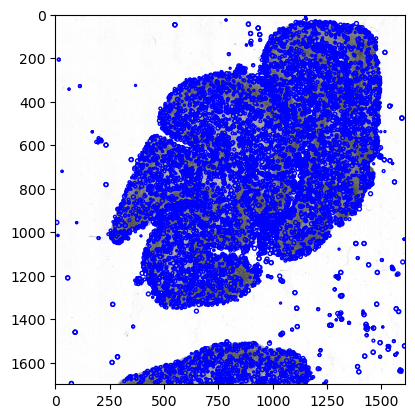

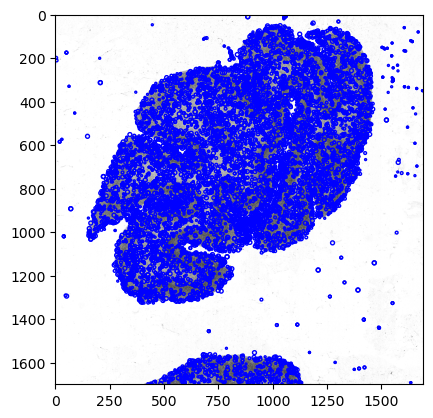

In [114]:
import skimage as ski
from skimage import transform
from skimage.feature import SIFT
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
import os

test_path = "./test_pics"

images = []
keypoints = []
descriptors = []
i=0
for file in os.listdir(test_path):

    # Load the image
    img = ski.io.imread(os.path.join(test_path, file))
    images.append(img)

    # create a SIFT detector
    detector = SIFT()
    detector.detect_and_extract(img)

    keypoints.append(detector.keypoints)
    descriptors.append(detector.descriptors)

    # print the number of keypoints
    print(detector.keypoints.shape)
    im, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
            2 ** detector.scales, facecolors='none', edgecolors='b')
    i+=1

In [2]:
from skimage.feature import match_descriptors

matches01 = match_descriptors(descriptors[0], descriptors[1], max_ratio= 0.7, cross_check=True)
print(matches01.shape)
matches02 = match_descriptors(descriptors[1], descriptors[0], max_ratio= 0.7, cross_check=True)
print(matches02.shape)
print("the cross check of the matches in skimage is not symmetric")

(64, 2)
(48, 2)
the cross check of the matches in skimage is not symmetric


In [104]:
# Implement a matching algorithm by our own
# Check the Eucledean distance between the descriptors
from scipy.spatial.distance import cdist
import numpy as np

# The commented function is computational expensive
# def match_feature(descriptor1, descriptor2, max_ratio=0.5, cross_check=False):
#     dists = cdist(descriptor1, descriptor2)

#     # Find the two smallest distances by sorting the distances
#         # sort the distances, keep both indices and values
#     indices = dists.argsort(axis=1, kind = 'mergesort')
#     dists_sorted = np.sort(dists, axis=1, kind = 'mergesort')
#         # calcualte the ratio between the smallest and second smallest distance
#         # and create a mask
#     mask = (dists_sorted[:, 0] / dists_sorted[:, 1]) < max_ratio

#     # If cross_check is True, check if the match is mutual
#     dists_T = dists.T

#     matches = np.array([mask.nonzero()[0], indices[mask.nonzero()][:, 0]]).T
#     return matches


def match_feature(descriptor1, descriptor2, max_ratio=0.7, cross_check=False):
    dists = cdist(descriptor1, descriptor2)

    # find the two smallest distances by sorting the distances
    mask_matrix1 = create_mask(dists, max_ratio)
    mask_matrix2 = np.ones(dists.shape, dtype=bool)
    if cross_check:
        mask_matrix2 = create_mask(dists.T, max_ratio).T
    return np.array((mask_matrix1 & mask_matrix2).nonzero()).T

def create_mask(dists_orig, max_ratio):
    dists = dists_orig.copy()
    indices_1 = np.arange(dists.shape[0])
    indices_2 = dists.argmin(axis=1)
    smallest_dist = dists[indices_1, indices_2]
    dists[indices_1, indices_2] = np.inf
    second_smallest_dist = dists[indices_1, dists.argmin(axis=1)]
    mask = smallest_dist / second_smallest_dist < max_ratio
    mask_matrix = np.zeros(dists.shape, dtype=bool)
    mask_matrix[indices_1[mask], indices_2[mask]] = True
    return mask_matrix

matches = match_feature(descriptors[0], descriptors[1], max_ratio=0.7, cross_check=True)
print("The shape of the matches is: ", matches.shape)

The shape of the matches is:  (95, 2)


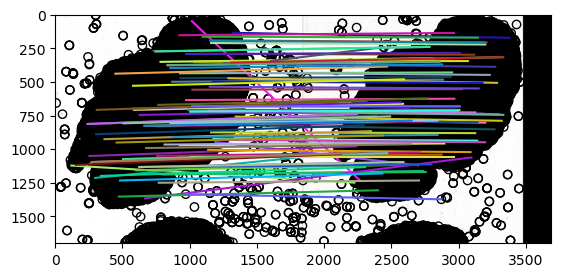

In [105]:
from matplotlib import pyplot as plt
from skimage.feature import plot_matches

fig, ax = plt.subplots(nrows=1, ncols=1)

plot_matches(ax, images[0], images[1], keypoints[0], keypoints[1], matches)



# Removing outliers using RANSAC 

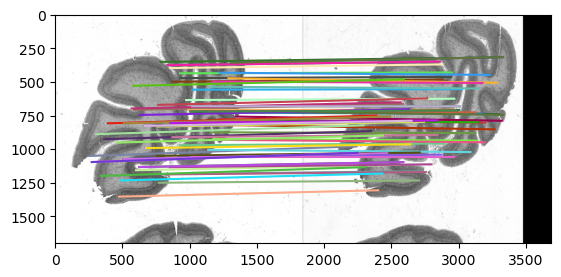

In [112]:
def number_of_rounds(p = 0.3, P = 0.99, n = 2):
    # p: the probability that at least one random sample is free from outliers
    # P: the probability that the algorithm produces the correct model
    # n: the number of samples needed to estimate the model
    return int(np.log(1 - P) / np.log(1 - (1 - p) ** n))

def ransac(keypoints1, keypoints2, matches, p = 0.3, P = 0.99):
    num_rounds = number_of_rounds(p, P, 1)
    vecs = keypoints1[matches[:, 0]] - keypoints2[matches[:, 1]]
    samples = np.random.choice(vecs.shape[0], (num_rounds, 1), replace=True).squeeze()
    inliers = np.empty(0)
    for sample in samples:
        vecs_temp = vecs.copy()
        vecs_temp = vecs_temp - vecs[sample]
        # check the distance between the vectors
        threshold = 60
        mask = (np.linalg.norm(vecs_temp, axis=1) < threshold) & (np.linalg.norm(vecs_temp, axis=1) > 0)
        if (len(mask.nonzero()[0]) > len(inliers.nonzero()[0])):
            inliers = mask
    # print("The number of inliers is: ", len(inliers.nonzero()[0]))
    return matches[inliers]

matches_remove = ransac(keypoints[0], keypoints[1], matches, p = 0.6, P = 0.999)

fig, ax = plt.subplots(nrows=1, ncols=1)
plot_matches(ax, images[0], images[1], keypoints[0], keypoints[1], matches_remove, only_matches=True)

# Create a translation as a starting point 

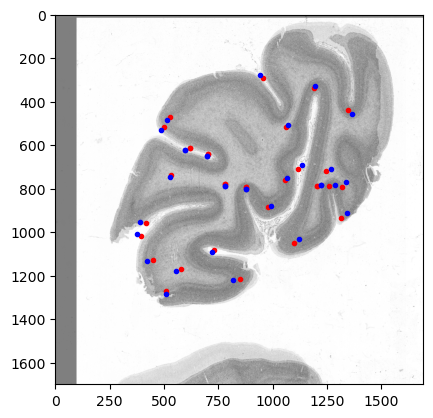

In [59]:
T = np.eye(3)
T[:2, 2] = (keypoints[0][matches_remove[:, 0]] - keypoints[1][matches_remove[:, 1]]).mean(axis=0)

def transform_image(image, T):
    x_size, y_size = image.shape
    x_coords, y_coords = np.mgrid[:x_size, :y_size]
    points = np.stack([x_coords.ravel(), y_coords.ravel()], axis=1)
    points_h = np.concatenate([points, np.ones((len(points), 1))], axis=1)
    points_t = (T @ points_h.T).T

    output_img = np.zeros_like(image)

    points_t = points_t.round().astype(int)
    inside_mask = (points_t[:, 0] >= 0) & (points_t[:, 0] < x_size) & (points_t[:, 1] >= 0) & (points_t[:, 1] < y_size)
    points_t_inside = points_t[inside_mask, :]
    # get coordinate
    x_coords_t, y_coords_t, _ = points_t_inside.T
    x_src, y_src = points[inside_mask, :].T
    # Attention: flip x and y again!
    output_img[x_coords_t, y_coords_t] = image[x_src, y_src]

    return output_img

def transform_points(keypoints, T):
    points_h = np.concatenate([keypoints, np.ones((len(keypoints), 1))], axis=1)
    return ((T @ points_h.T).T)[:,:2]


image_1 = transform_image(images[1], T)
keypoints_1 = transform_points(keypoints[1], T)

ax = plt.subplot()

# Display the image
ax.imshow(images[0], cmap='gray', alpha=0.5)
ax.imshow(images[1], cmap='Blues', alpha=0.5)
ax.plot(keypoints[0][matches_remove[:, 0]][:, 1], keypoints[0][matches_remove[:, 0]][:, 0], 'r.')
ax.plot(keypoints_1[matches_remove[:, 1]][:, 1], keypoints_1[matches_remove[:, 1]][:, 0], 'b.')

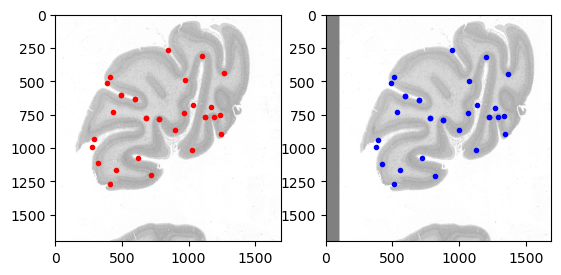

In [58]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[1], cmap='gray', alpha=0.5)
ax[1].imshow(image_1, cmap='gray', alpha=0.5)
ax[0].plot(keypoints[1][matches_remove[:, 1]][:, 1], keypoints[1][matches_remove[:, 1]][:, 0], 'r.')
ax[1].plot(keypoints_1[matches_remove[:, 1]][:, 1], keypoints_1[matches_remove[:, 1]][:, 0], 'b.')

In [68]:
tform = transform.ProjectiveTransform()
tform.estimate(keypoints[0][matches_remove[:, 0]], keypoints[1][matches_remove[:, 1]])
tform.params

array([[ 9.58976189e-01, -2.80631555e-02,  2.14758545e+01],
       [-8.38992544e-03,  1.02334946e+00, -1.29962818e+02],
       [-1.82708659e-05, -9.22649663e-06,  1.00000000e+00]])

In [74]:
tform.inverse

<ProjectiveTransform(matrix=
    [[ 1.04267119e+00,  2.84244304e-02, -1.86981358e+01],
     [ 1.09805674e-02,  9.78628987e-01,  1.26949564e+02],
     [ 1.91518177e-05,  9.54865601e-06,  1.00082967e+00]]) at 0x7db814629610>

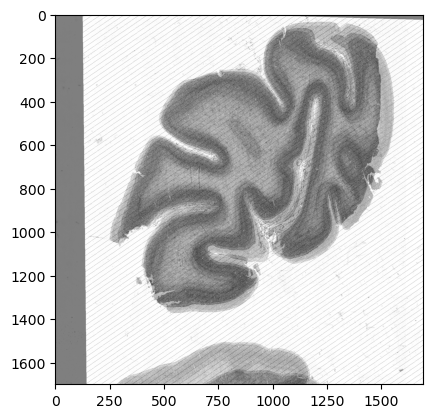

In [75]:
fig, ax = plt.subplots()
ax.imshow(images[0], cmap='gray')
ax.imshow(transform_image(images[1], tform.inverse.params), cmap='gray', alpha=0.5)

# Put all things together

In [126]:
path = "./data/png"

images = []
keypoints = []
descriptors = []
i=0
for file in os.listdir(path):

    # Load the image
    img = ski.io.imread(os.path.join(path, file))
    images.append(img[:1500, :])

    # create a SIFT detector
    detector = SIFT()
    detector.detect_and_extract(img)

    keypoints.append(detector.keypoints)
    descriptors.append(detector.descriptors)

    print("Processing image ", i)
    i+=1

Processing image  0
Processing image  1
Processing image  2
Processing image  3
Processing image  4
Processing image  5
Processing image  6
Processing image  7
Processing image  8
Processing image  9
Processing image  10
Processing image  11
Processing image  12
Processing image  13
Processing image  14
Processing image  15
Processing image  16
Processing image  17
Processing image  18
Processing image  19
Processing image  20
Processing image  21
Processing image  22
Processing image  23
Processing image  24
Processing image  25


In [129]:
images_transformed = [images[0]]
for i in range(1, len(images)):
    print("Processing image ", i)
    matches = match_feature(descriptors[0], descriptors[i], max_ratio=0.6, cross_check=True)
    matches_remove = ransac(keypoints[0], keypoints[i], matches, p = 0.3, P = 0.999)
    tform = transform.AffineTransform()
    tform.estimate(keypoints[0][matches_remove[:, 0]], keypoints[i][matches_remove[:, 1]])
    images_transformed.append(transform_image(images[i], tform.inverse.params))

Processing image  1
Processing image  2
Processing image  3
Processing image  4
Processing image  5
Processing image  6
Processing image  7
Processing image  8
Processing image  9
Processing image  10
Processing image  11
Processing image  12
Processing image  13
Processing image  14
Processing image  15
Processing image  16
Processing image  17
Processing image  18
Processing image  19
Processing image  20
Processing image  21
Processing image  22
Processing image  23
Processing image  24
Processing image  25


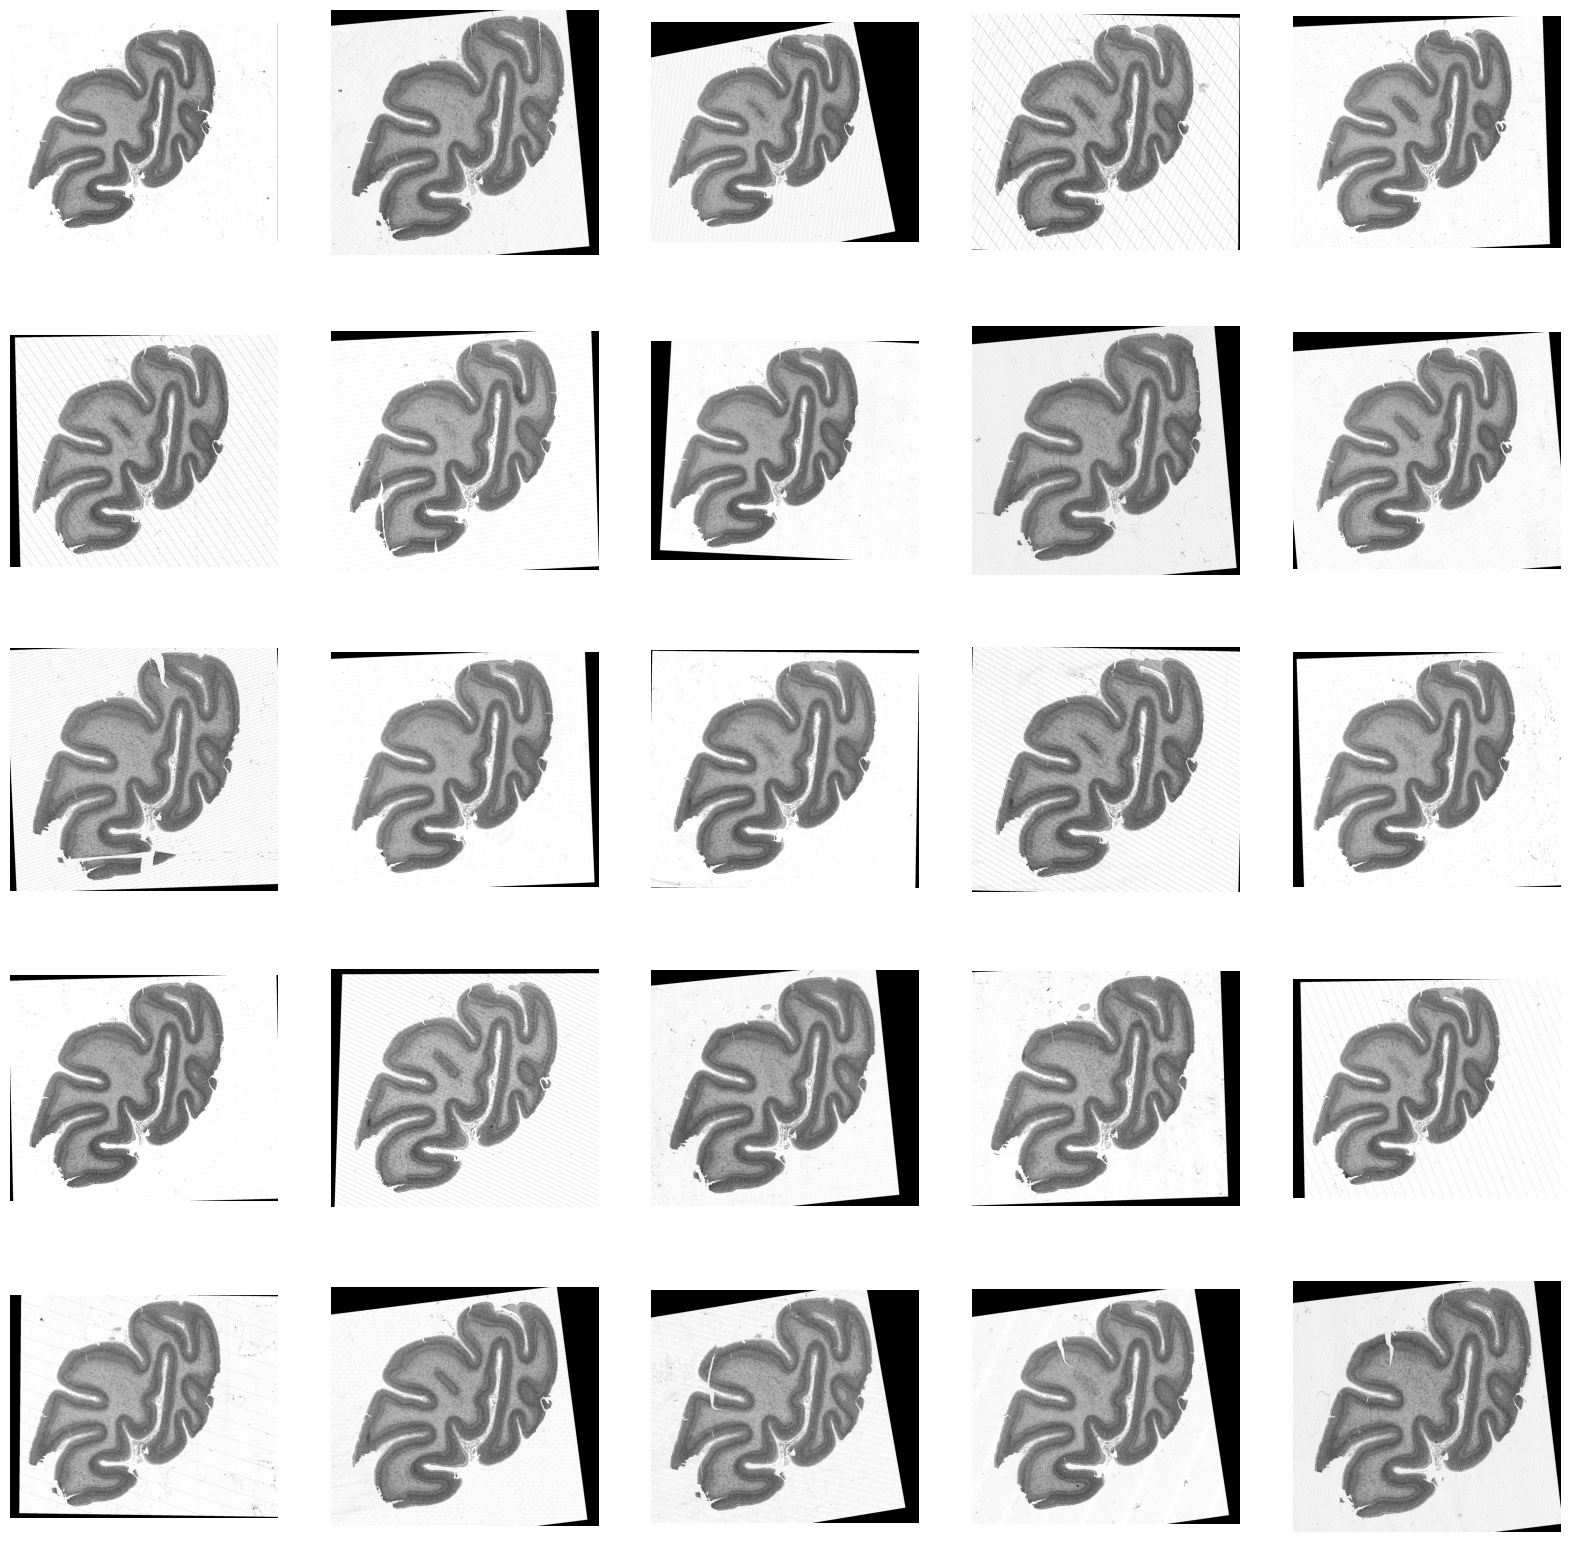

In [130]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for i in range(5):
    for j in range(5):
        ax[i, j].imshow(images_transformed[i*5+j], cmap='gray')
        ax[i, j].axis('off')

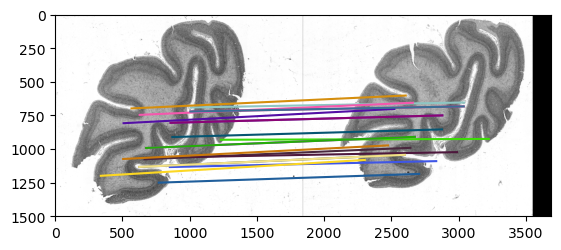

In [131]:
# plot matches of the first image and the 23rd image
fig, ax = plt.subplots(nrows=1, ncols=1)
matches = match_feature(descriptors[0], descriptors[23], max_ratio=0.6, cross_check=True)
matches_remove = ransac(keypoints[0], keypoints[23], matches, p = 0.3, P = 0.999)
plot_matches(ax, images[0], images[23], keypoints[0], keypoints[23], matches_remove, only_matches=True)

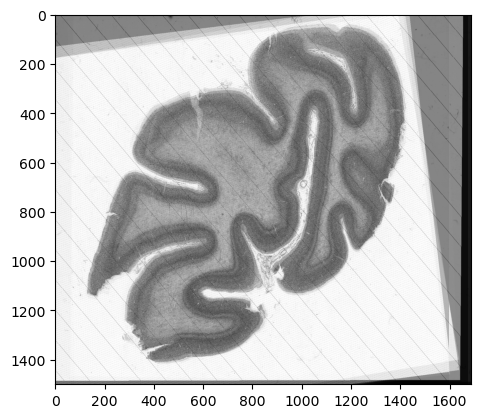

In [132]:
ax = plt.subplot()
for i in range(len(images_transformed)):
    ax.imshow(images_transformed[i], cmap='gray', alpha=0.5)